In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,classification_report
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model,Sequential

In [2]:
df=pd.read_csv(r"D:\Karir\Portofolio\NVDA\NVDA (1).csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2020-01-02 to 2021-09-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       432 non-null    float64
 1   High       432 non-null    float64
 2   Low        432 non-null    float64
 3   Close      432 non-null    float64
 4   Adj Close  432 non-null    float64
 5   Volume     432 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 23.6 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,59.687500,59.977501,59.180000,59.977501,59.833767,23753600
2020-01-03,58.775002,59.457500,58.525002,59.017502,58.876064,20538400
2020-01-06,58.080002,59.317501,57.817501,59.264999,59.122974,26263600
2020-01-07,59.549999,60.442501,59.097500,59.982498,59.838753,31485600
2020-01-08,59.939999,60.509998,59.537498,60.095001,59.950985,27710800


In [3]:
# Open = Stock price the first time the transaction was made on that day
# High = Highest stock price on that day
# Low = Lowest stock price on that day
# Close = Final stock price on that day

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,432.000000,432.000000,432.000000,432.000000,432.000000,4.320000e+02
mean,126.504143,128.558235,124.289427,126.585243,126.482097,4.238487e+07
std,44.979230,45.320273,44.463754,44.970496,45.005368,2.147389e+07
min,50.025002,52.485001,45.169998,49.099998,49.011627,9.788400e+06
25%,89.625628,91.055628,87.421875,89.293747,89.173720,2.669890e+07
50%,130.779999,133.068748,128.857506,130.301254,130.184250,3.640120e+07
75%,147.050629,148.284371,142.841251,145.746246,145.617271,5.429080e+07
max,228.330002,230.429993,225.509995,228.429993,228.429993,1.463684e+08


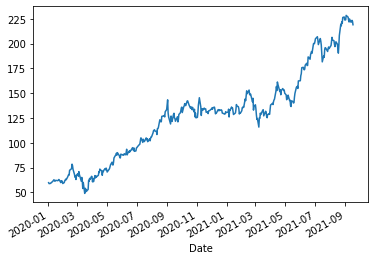

In [5]:
df['Adj Close'].plot()

In [6]:
A=df.drop(['Adj Close','Close'],axis=1)
A.corrwith(df['Adj Close']) #Determine the correlation of Adj Close with other columns

Open      0.997971
High      0.999110
Low       0.999131
Volume   -0.329291
dtype: float64

In [7]:
test=df
feature_columns=['Open','High','Low','Volume','Adj Close']

In [8]:
#Scaling Data
scaler=MinMaxScaler()
feature_minmax_transform_data=scaler.fit_transform(test[feature_columns])
feature_minmax_transform=pd.DataFrame(columns=feature_columns,data=feature_minmax_transform_data,index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume,Adj Close
Date,,,,,
2020-01-02,0.054191,0.042106,0.077687,0.102249,0.060318
2020-01-03,0.049073,0.039183,0.074055,0.078708,0.054980
2020-01-06,0.045175,0.038397,0.070131,0.120627,0.056356
2020-01-07,0.053420,0.044719,0.077229,0.158861,0.060346
2020-01-08,0.055607,0.045098,0.079669,0.131223,0.060971


In [9]:
target_adj_close=pd.DataFrame(feature_minmax_transform['Adj Close'])
target_adj_close=target_adj_close.shift(-1) #Add empty space for prediction data
validation_y=target_adj_close[-90:-1]
target_adj_close=target_adj_close[:-90]

feature_minmax_transform=feature_minmax_transform.drop(['Adj Close'], axis=1)
validation_x=feature_minmax_transform[-90:-1]
feature_minmax_transform=feature_minmax_transform[:-90]
#Split data to validation data and training data with rate 1:9

In [10]:
ts_split=TimeSeriesSplit(n_splits=10) #Sequential using TimeSeriesSplit to split data
for train_index, test_index in ts_split.split(feature_minmax_transform):
    X_train,X_test=feature_minmax_transform[:len(train_index)],feature_minmax_transform[len(train_index):]
    Y_train,Y_test=target_adj_close[:len(train_index)].values.ravel(),target_adj_close[len(train_index):].values.ravel()
#values.ravel() to take value only

In [11]:
#Check test and train data
X_test.shape,X_train.shape,Y_test.shape,Y_train.shape

((31, 4), (311, 4), (31,), (311,))

In [12]:
X_train=np.array(X_train)
X_test=np.array(X_test)

X_tr_t=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_ts_t=X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [13]:
#Create model using LSTM
K.clear_session()
model=Sequential()
model.add(LSTM(20,input_shape=(1,X_train.shape[1]),activation='relu',return_sequences=False))
model.add(Dense(1)) #1 output
model.compile(loss='mean_squared_error',optimizer='adam')
#Early Stopping : stop the training process for avoid overfitting 
early_stop=EarlyStopping(monitor='loss',patience=5,verbose=1)
history_model=model.fit(X_tr_t,Y_train,epochs=200,batch_size=8,verbose=1,shuffle=False,callbacks=[early_stop])

Epoch 1/200
39/39 [==============================] - 0s 5ms/step - loss: 0.0657
Epoch 2/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0262
Epoch 3/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 4/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 5/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 6/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 7/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 8/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 9/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 10/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 11/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 12/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 13/200
39/39 [=================

In [14]:
#Predict data test
y_pred_test=model.predict(X_ts_t)

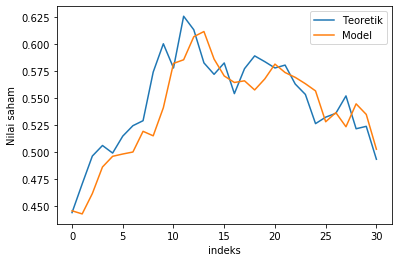

In [15]:
#Plot real data test and predict data test
plt.plot(Y_test, label='Teoretik')
plt.plot(y_pred_test, label='Model')
plt.xlabel("indeks")
plt.ylabel('Nilai saham')
plt.legend()
plt.show()

In [26]:
#Evaluate the performance of model
r2_score(Y_test,y_pred_test)

0.6807431641672612